In [1]:
#LIBRARY
from typing import List
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
#Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

#min-max scaling function
from sklearn.preprocessing import MinMaxScaler

#keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('store5.csv')

Saving store5.csv to store5 (1).csv


In [8]:
df.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-01,BABY CARE,0.0,0
2,2013-01-01,BEAUTY,0.0,0
3,2013-01-01,BEVERAGES,0.0,0
4,2013-01-01,BOOKS,0.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [7]:
#Konversi kolom 'date' menjadi datetime
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

#Hapus fitur yang tidak diperlukan
df.drop(columns=["id", "store_nbr", "dcoilwtico"], inplace=True)

In [9]:
#create function for filtering
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df


#function adfuller test with looping d
def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")

<Axes: ylabel='family'>

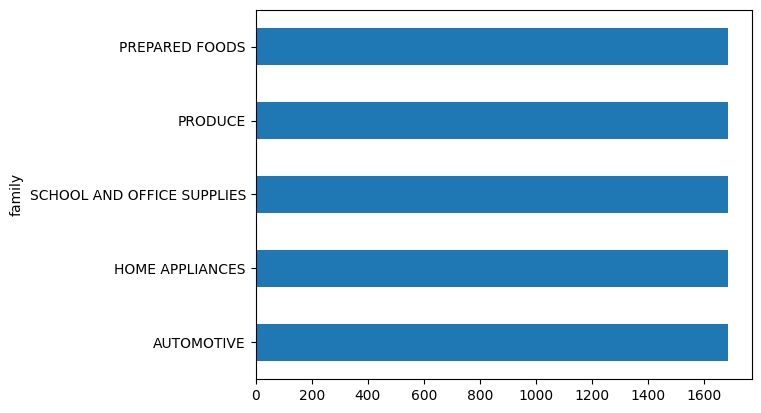

In [10]:
#check
df.family.value_counts().nlargest().plot(kind="barh")

LINGERIE EDA

In [11]:
df_lingerie = filter_family(df,"LINGERIE")
df_lingerie.head()

,date,family,sales,onpromotion
0,2013-01-01,LINGERIE,0.0,0
1,2013-01-02,LINGERIE,44.0,0
2,2013-01-03,LINGERIE,36.0,0
3,2013-01-04,LINGERIE,23.0,0
4,2013-01-05,LINGERIE,43.0,0


<Axes: xlabel='date'>

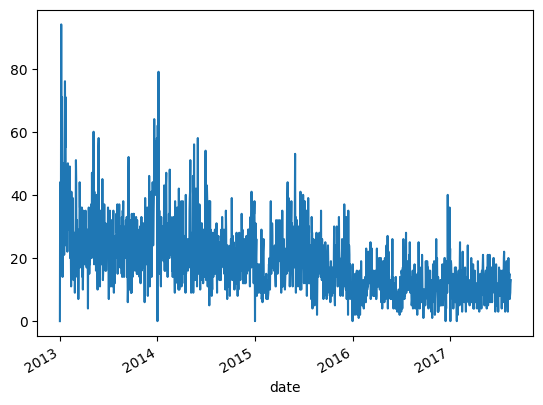

In [12]:
df_lingerie.set_index("date").sales.plot()

<Axes: xlabel='date'>

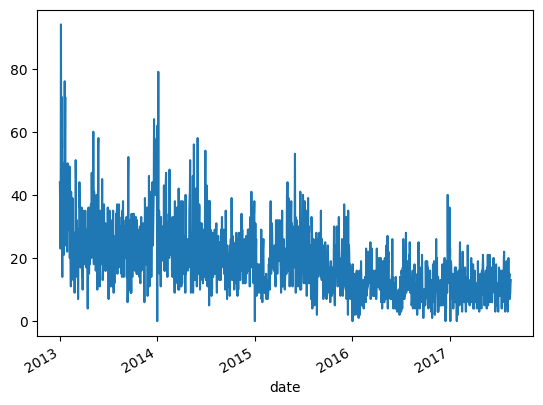

In [13]:
df_lingerie.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

<Axes: xlabel='date'>

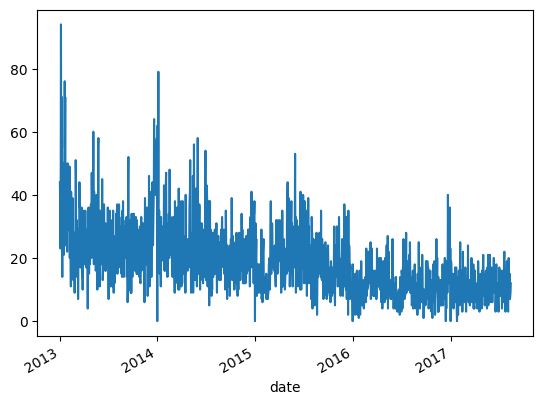

In [14]:
df_lingerie = df_lingerie.iloc[1:-1,:].reset_index(drop=True)
df_lingerie.set_index("date").sales.plot()

<Axes: xlabel='date'>

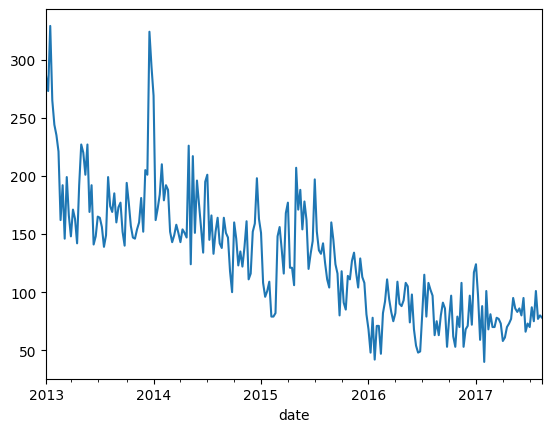

In [15]:
df_lingerie.set_index("date").sales.resample("W-MON").sum().plot()

In [16]:
#Menetapkan 'date' sebagai indeks
df_lingerie.set_index("date", inplace=True)

#Meresample berdasarkan minggu dan menjumlahkan nilai 'sales', tetap mempertahankan kolom lainnya
df_lingerie = df_lingerie.resample("W-MON").agg({
    'sales': 'sum',
})

df_lingerie['sales'] = np.log(df_lingerie['sales'])
print(df_lingerie.head())

               sales
date                
2013-01-07  5.655992
2013-01-14  5.609472
2013-01-21  5.796058
2013-01-28  5.579730
2013-02-04  5.497168


In [17]:
df_lingerie

,sales
date,
2013-01-07,5.655992
2013-01-14,5.609472
2013-01-21,5.796058
2013-01-28,5.579730
2013-02-04,5.497168
...,...
2017-07-17,4.317488
2017-07-24,4.615121
2017-07-31,4.343805


UJI STATIONER

In [18]:
#Split data
#Scalling

scaler = MinMaxScaler()
#df_lingerie.drop(['family'], axis=1, inplace=True)
x = df_lingerie['sales'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

In [19]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X) - sequence_length):
        data.append(X[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(174, 22, 1) (174, 1) (44, 22, 1) (44, 1)


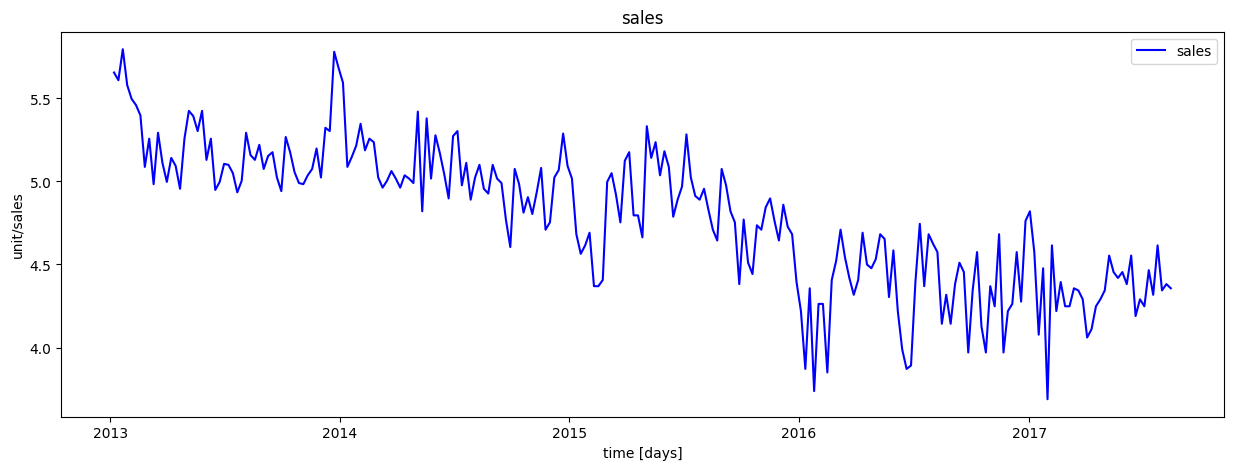

In [21]:
plt.figure(figsize=(15, 5));
plt.plot(df_lingerie['sales'], color='blue', label='sales')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('sales')
plt.xlabel('time [days]')
plt.ylabel('unit/sales')
plt.legend(loc='best')
plt.show()

In [22]:
#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(window,1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 4s 155ms/step - loss: 0.3235 - val_loss: 0.0783
Epoch 2/100
5/5 [==============================] - 0s 18ms/step - loss: 0.2665 - val_loss: 0.0505
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 0.1563 - val_loss: 0.0091
Epoch 4/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0380 - val_loss: 0.1233
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0526 - val_loss: 0.0437
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0227 - val_loss: 0.0109
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0306 - val_loss: 0.0127
Epoch 8/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0213 - val_loss: 0.0332
Epoch 9/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0209 - val_loss: 0.0464
Epoch 10/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0210 - val_loss: 0.0265
Epoch 11/100
5/5 [

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

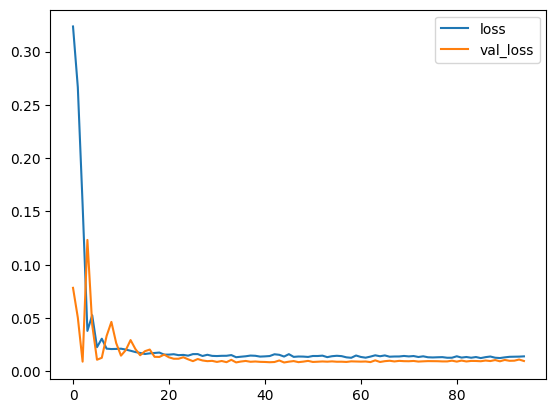

In [24]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

MODEL PREDICT

In [25]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 7ms/step


In [26]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(44, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(44, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(44, 1)
(44, 1)


In [27]:
df_lingerie.shape

(241, 1)

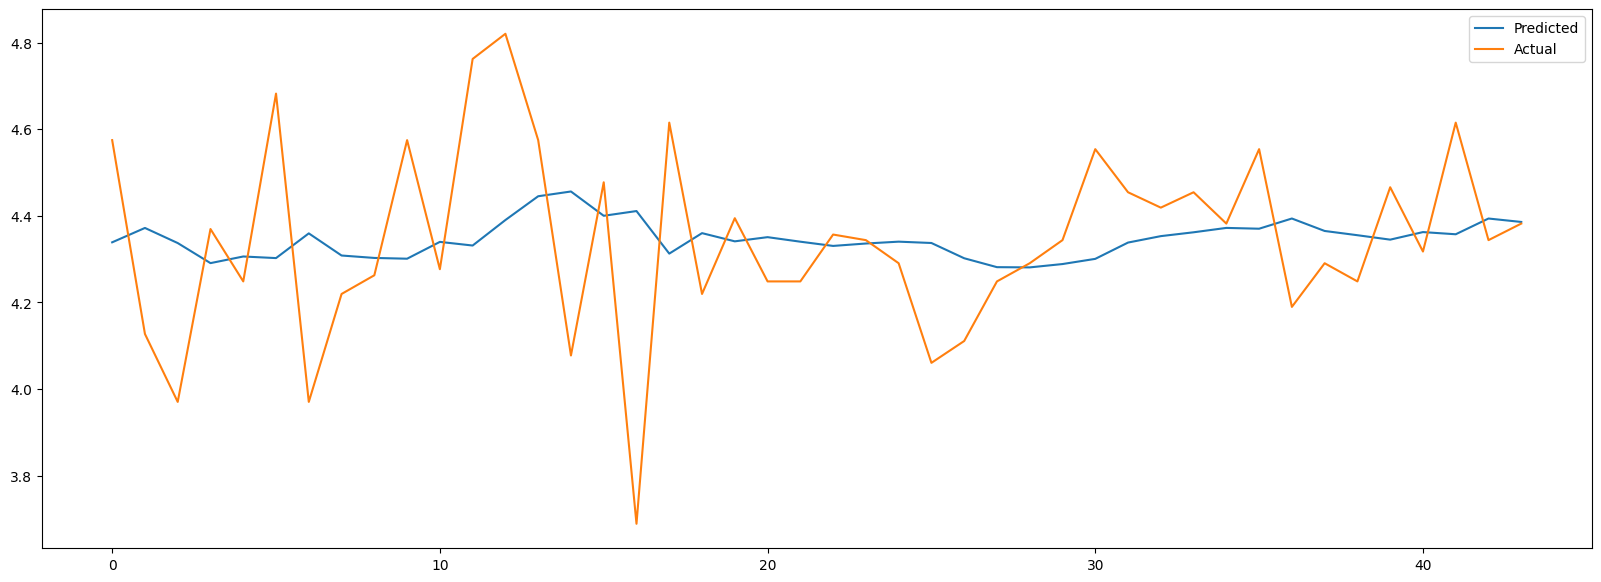

In [28]:
plot_x = df['date'].copy()
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-44:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [29]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.23 RMSE
Test Score: 0.22 RMSE


In [30]:
lingerie_sales = df_lingerie.sales.values.astype('float32')
lingerie_sales = lingerie_sales.reshape(len(lingerie_sales), 1)
trainPredictPlot = np.empty_like(lingerie_sales)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+ 22, :] = trainPredict
testPredictPlot = np.empty_like(lingerie_sales)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(lingerie_sales) - testPredict.shape[0]):len(lingerie_sales), :] = testPredict

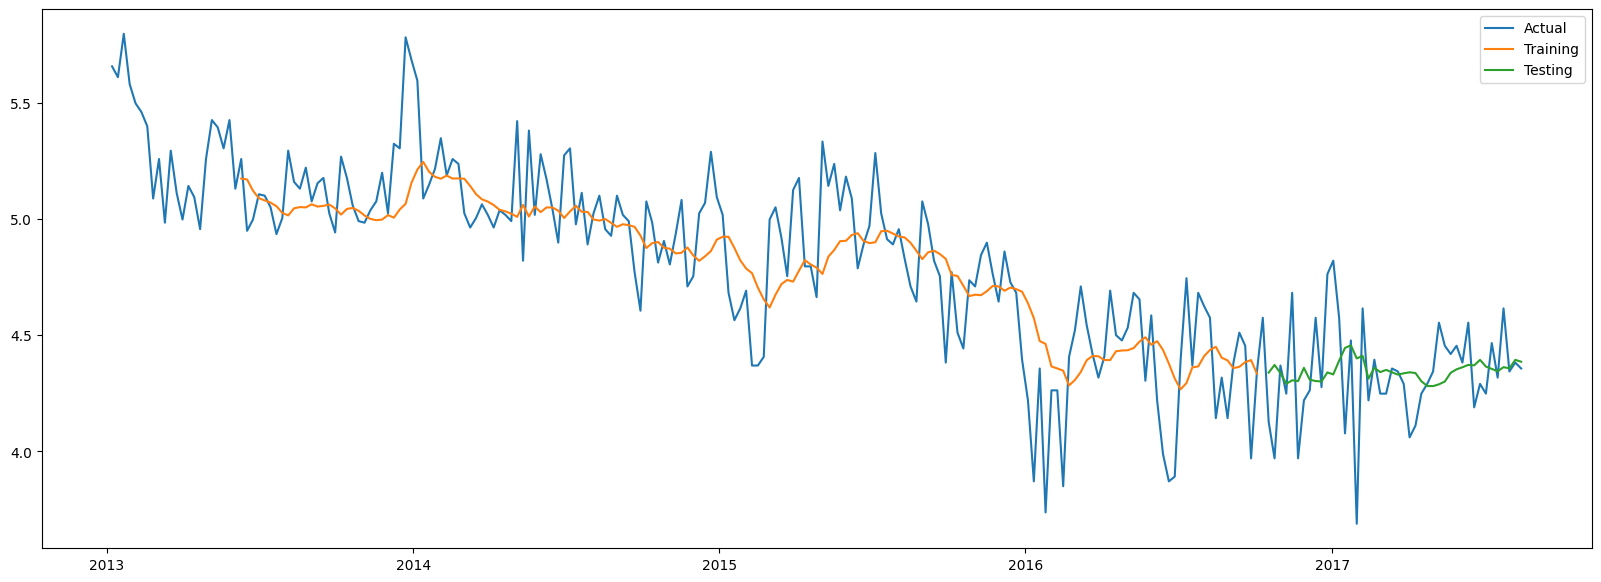

In [31]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(lingerie_sales, columns=["sales"], index=df_lingerie.index).sales, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["sales"], index=df_lingerie.index).sales, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["sales"], index=df_lingerie.index).sales, label='Testing')
plt.legend(loc='best')
plt.show()

MODEL GRU

In [32]:
# Stack LSTM architecture
model2 = Sequential()
# GRU layer with Dropout regularisation
model2.add(GRU(units=20, input_shape=(window,1)))
model2.add(Dropout(0.2))

# The output layer
model2.add(Dense(units=20, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 3s 130ms/step - loss: 0.3318 - val_loss: 0.0878
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 0.3124 - val_loss: 0.0790
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 0.2881 - val_loss: 0.0677
Epoch 4/100
5/5 [==============================] - 0s 27ms/step - loss: 0.2566 - val_loss: 0.0535
Epoch 5/100
5/5 [==============================] - 0s 29ms/step - loss: 0.2130 - val_loss: 0.0364
Epoch 6/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1592 - val_loss: 0.0186
Epoch 7/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0971 - val_loss: 0.0082
Epoch 8/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0417 - val_loss: 0.0250
Epoch 9/100
5/5 [==============================] - 0s 26ms/step - loss: 0.0240 - val_loss: 0.0736
Epoch 10/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0329 - val_loss: 0.0729
Epoch 11/100
5/5 [

<Axes: >

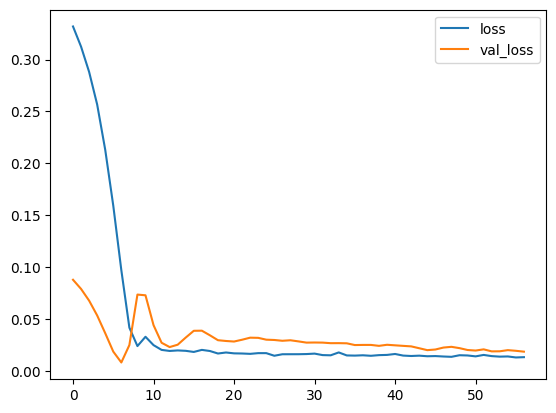

In [33]:
%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()

In [34]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 15ms/step


In [35]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.23 RMSE
Test Score: 0.27 RMSE


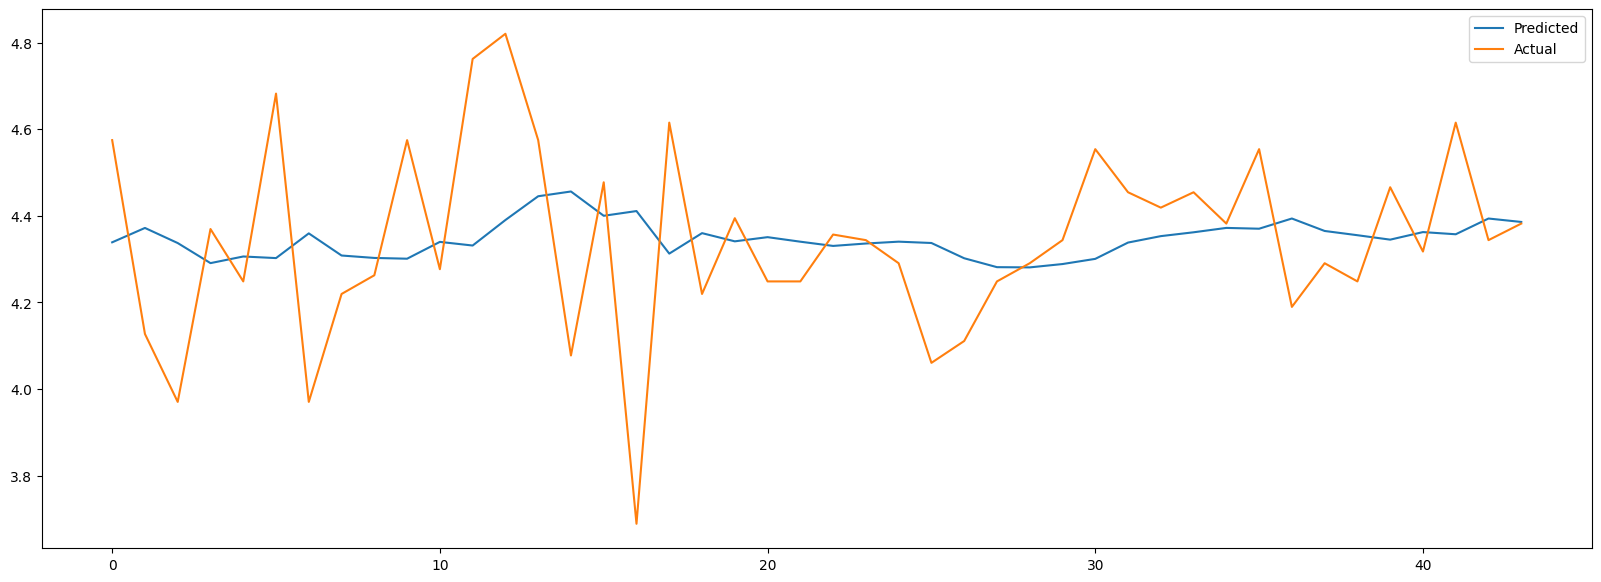

In [36]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()